In [285]:
import rospy
import jupyros
from IPython.display import display

from geometry_msgs.msg import Twist, Vector3    #for cmd_vel topic

from jupyros import ros3d
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
import ipywidgets as widgets
import actionlib
import matplotlib.pyplot as plt
import tf
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from tf.transformations import quaternion_matrix
import numpy as np
from matplotlib.animation import FuncAnimation
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal, MoveBaseActionGoal
import os  
global x
global y
rospy.init_node('jupy_user_interface')


In [286]:
def set_cmd_vel(direction):
#initialize a Twist object for the publisher
    init = Vector3(0, 0, 0)
    vel = Twist( init, init)
    
    lin_vel = 0.5
    ang_vel = 0.5
    
    #define velocity to actuate a direction
    if direction == 'u':
        vel.linear.x = lin_vel 
        vel.angular.z = 0
    elif direction == 'd':
        vel.linear.x = -lin_vel 
        vel.angular.z = 0
    elif direction == 'l':
        vel.angular.z = ang_vel
        vel.linear.x = 0
    elif direction == 'r':
        vel.angular.z = -ang_vel
        vel.linear.x = 0
    
    
    #initialize the publisher
    pub = rospy.Publisher('remap_cmd_vel',Twist, queue_size=10)
    
    #pubblic on topic remap_cmd_vel to the robot
    pub.publish(vel)

In [287]:
def drive_interface():
    #drive manually the robot and change the driving mode

    #display(buttonUP, buttonDOWN, buttonLEFT, buttonRIGHT, buttonPAUSE, toggle)
    display(drive)
    display(check)
    #display(A5)  
    
    up.on_click(on_button_clicked_U)
    down.on_click(on_button_clicked_D)
    left.on_click(on_button_clicked_L)
    right.on_click(on_button_clicked_R)
    
    check.observe(check_obstacles, names='value')
    
    #A5.on_click(on_button_clicked_F)
    
    #display the ros3d map
    display_map()

In [288]:
def send_button_action(b):
    #if b == s1:
        with output:
            print(x,y)
            x.disabled = True
            y.disabled = True
            callback_case1(x,y)

In [289]:
def case2():  
    #display(control)
    
    drive_interface()

def check_obstacles(b):
    rospy.set_param("/controller", check.value)

In [290]:
def callback_case1(x,y):
    print("i am in the function")
    client = actionlib.SimpleActionClient('move_base', MoveBaseAction)
    
    #waiting for the connection with the server
    print("i am waiting")
    client.wait_for_server()
    print("i passed the wait")
    
    #create the goal
    goal = MoveBaseGoal()
    
    #set the goal parameter
    goal.target_pose.header.frame_id = 'map'
    goal.target_pose.pose.orientation.w = 1
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y
    
    #send the goal
    client.send_goal(goal)
    pub_goal = rospy.Publisher('/move_base/goal', MoveBaseActionGoal, queue_size = 1000)
    send_button.on_click(send_button_action)
    
    finished_within_time = client.wait_for_result(rospy.Duration(60.0))
    if not finished_within_time:
        client.cancel_goal()
        rospy.loginfo("Timed out achieving goal")
        return -1
    else:
        rospy.loginfo("Goal succeeded!")
        return 1

In [291]:
def on_button_clicked_U(a):
    set_cmd_vel('u')
def on_button_clicked_D(a):
    set_cmd_vel('d')
def on_button_clicked_L(a):
    set_cmd_vel('l')
def on_button_clicked_R(a):
    set_cmd_vel('r')

In [292]:
#button activation
def on_button_clicked_A1(a):
        with output:
            print("case 1")
            display(x,y,send_button)
            send_button.on_click(send_button)
            #A4.on_click(callback_case1)
            
def on_button_clicked_A2(a):
        with output:
            display(velocity)
            case2()
            print("case 2")
            
def on_button_clicked_A3(a):
        with output:
            case2()
            print("case 3")
            check.observe(check_obstacles, names='value')
            display(check)
               
  

In [293]:
#driving buttons
up = Button(description='UP', layout=Layout(grid_area='b1'))
left = Button(description='LEFT', layout=Layout(grid_area='b2'))
right = Button(description='RIGHT', layout=Layout( grid_area='b3'))
down = Button(description='DOWN', layout=Layout(grid_area='b4'))

HBox([VBox([right, down]),VBox([up, left])])

drive=GridBox(children=[up, left, right, down],layout=Layout(width='50%', grid_template_rows='auto auto',
    grid_template_columns='33% 33% 33% 33%',
    grid_template_areas='''
    " . b1 . "
    "b2 . b3 "
    " . b4 . "
    ''')
)

check = widgets.Checkbox(
    value = True,
    description='active obstacle avoidance'
)


velocity=widgets.FloatSlider(min=0, max=5, step=0.1, value=10.5, description='velocity control');

x = widgets.FloatText(description="x coordinate: ")
y = widgets.FloatText(description="y coordinate: ")


send_button = widgets.Button(
    value=False,
    description='SEND',
    disabled=False,
    button_style='', 
    tooltip='Description',
    icon='check' 
)


In [294]:
A1 = widgets.Button(
    value=False,
    description='choose X and Y',
    button_style='',
    disabled=False, 
    tooltip='Description',
)

A2 = widgets.Button(
    value=False,
    description='use keyboard',
    button_style='', 
    disabled=False,
    tooltip='Description',
)

A3 = widgets.Button(
    value=False,
    description='avoid obstacles',
    button_style='', 
    disabled=False,
    tooltip='Description',
)


#create an output cell
output = widgets.Output()

display(A1,A2,A3,output)


A1.on_click(on_button_clicked_A1)
A2.on_click(on_button_clicked_A2)
A3.on_click(on_button_clicked_A3)
send_button.on_click(send_button_action)


Button(description='choose X and Y', style=ButtonStyle(), tooltip='Description')

Button(description='use keyboard', style=ButtonStyle(), tooltip='Description')

Button(description='avoid obstacles', style=ButtonStyle(), tooltip='Description')

Output()

In [295]:
def display_map():
    
    #display a live map of the working enviroment of the robot 
    v = ros3d.Viewer()
    rc = ros3d.ROSConnection(url="ws://localhost:9090")
    tf_client = ros3d.TFClient(ros=rc, fixed_frame='map')

    laser_view = ros3d.LaserScan(topic="/scan", ros=rc, tf_client=tf_client)
    map_view = ros3d.OccupancyGrid(topic="/map", ros=rc, tf_client=tf_client, continuous=True)
    path = ros3d.Path(topic="/move_base/NavfnROS/plan", ros=rc,
    tf_client=tf_client)
    urdf = ros3d.URDFModel(ros=rc, tf_client=tf_client,
    path=os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000'))
    g = ros3d.GridModel()

    #v.objects = [g, laser_view, map_view, path, urdf]
    v.objects = [laser_view, map_view, urdf]

    display(v)

In [296]:
class Visualiser1:
    
    index = 0
    
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
    
    def plot_init(self):
        self.ax.set_xlim( -10, 10)
        self.ax.set_ylim( -10, 10)
        return self.ln
    
    def odom_callback(self, msg):
        
        self.index = self.index+1
        
        if self.index == 250:
            if len(self.y_data) < 500:
                self.y_data.append(msg.pose.pose.position.y)
            else:
                self.y_data.pop(0)
                self.y_data.append(msg.pose.pose.position.y)

            if len(self.x_data) < 500:
                self.x_data.append(msg.pose.pose.position.x)
            else:
                self.x_data.pop(0)
                self.x_data.append(msg.pose.pose.position.x)
                
            self.index = 0
        
            
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln
   
#polar plot visualizer function
class Visualiser2:
    
    def __init__(self):
        self.fig, self.ax = plt.subplots( subplot_kw={'projection': 'polar'} )
        self.ln, = plt.plot([], [], 'r.' )
        self.theta_data = np.arange( 0, np.pi, np.pi/720.0)   
        self.d_data = []
    
    def plot_init(self):
        self.ax.set_rmax(15)
        return self.ln
    
        
    def laserScan_callback(self, msg):
            self.d_data = msg.ranges
    
    def update_plot(self, frame):
        self.ln.set_data( self.theta_data, self.d_data )
        return self.ln

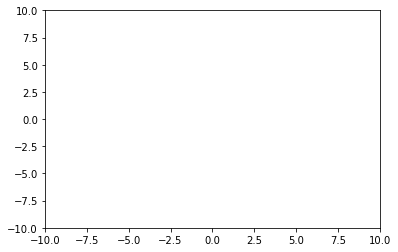

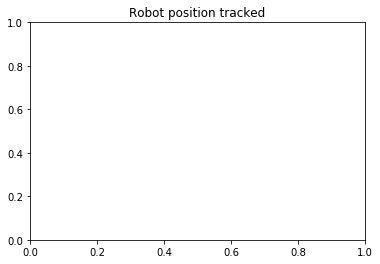

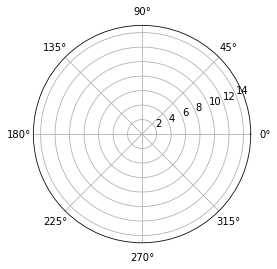

Text(0.5, 1.0, 'Laser scan tracked')

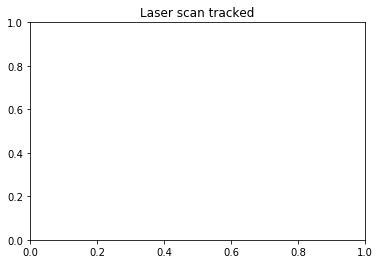

In [297]:
#visualization the position  the robot
vis = Visualiser1()
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show(block=True)
plt.title("Robot position tracked")

#visualization of the lasescaner sensor
vis2 = Visualiser2()
sub2 = rospy.Subscriber('/scan', LaserScan, vis2.laserScan_callback)
ani2 = FuncAnimation(vis2.fig, vis2.update_plot, init_func=vis2.plot_init)
plt.show(block=True)
plt.title("Laser scan tracked")

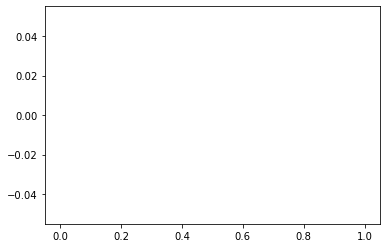

Text(0.5, 1.0, 'reached and not reached points')

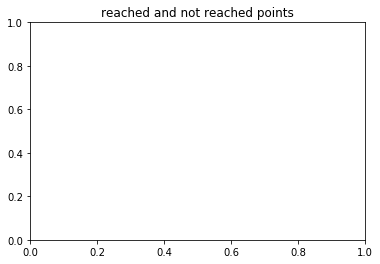

In [298]:
#histogram cell
fig, ax = plt.subplots()
_, _, ln, = ax.hist([])

def init():
    return ln,

def update(frame):
    ax.hist(reached_task, bins=3, color='green')
    return ln,

ani3 = FuncAnimation(fig, update, init_func=init)
plt.show()
plt.title("reached and not reached points")